<a href="https://colab.research.google.com/github/zia207/Survival_Analysis_Python/blob/main/Colab_Notebook/02_07_07_10_surval_analysis_coxnnet_osmic_data_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)


# 7.10 Cox-nnet for High-Throughput Omics Data: Predicting Patient Prognosis from Transcriptomics

This tutorial provides a comprehensive guide to implementing Cox-nnet for high-throughput omics data analysis, specifically focusing on predicting patient prognosis from RNA-Seq transcriptomics data. We will work with The Cancer Genome Atlas (TCGA) datasets, combining multiple cancer types to build a robust prognostic model.

**References:**
- Ching, T., Zhu, X., & Garmire, L. X. (2018). Cox-nnet: An artificial neural network method for prognosis prediction of high-throughput omics data. *PLoS computational biology*, 14(4), e1006076. https://pmc.ncbi.nlm.nih.gov/articles/PMC5909924/
- GitHub Repository: https://github.com/lanagarmire/cox-nnet
- TCGA Research Network: https://www.cancer.gov/tcga


##  Overview

### Cox-nnet for Omics Data

Cox-nnet is particularly well-suited for high-throughput omics data analysis because it can handle the high-dimensional nature of transcriptomics data (typically thousands of genes) while capturing non-linear relationships between gene expression and patient survival outcomes. Unlike traditional Cox regression, which struggles with high-dimensional data due to overfitting and computational limitations, Cox-nnet uses neural networks to learn complex patterns in gene expression profiles.

**Key Advantages for Omics Data:**

- **High-Dimensional Handling**: Can process thousands of features (genes) simultaneously
- **Non-Linear Relationships**: Captures complex gene-gene interactions and non-linear effects
- **Regularization**: Built-in regularization prevents overfitting in high-dimensional settings
- **Feature Learning**: Neural networks can learn relevant features automatically from raw expression data

### CGA Dataset Overview

The Cancer Genome Atlas (TCGA) is a comprehensive cancer genomics program that has molecularly characterized over 20,000 primary cancer and matched normal samples spanning 33 cancer types. For this tutorial, we will work with 10 cancer types:

1. **BLCA** - Bladder Urothelial Carcinoma
2. **BRCA** - Breast invasive carcinoma
3. **HNSC** - Head and Neck squamous cell carcinoma
4. **KIRC** - Kidney renal clear cell carcinoma
5. **LGG** - Brain Lower Grade Glioma
6. **LIHC** - Liver hepatocellular carcinoma
7. **LUAD** - Lung adenocarcinoma
8. **LUSC** - Lung squamous cell carcinoma
9. **OV** - Ovarian serous cystadenocarcinoma
10. **STAD** - Stomach adenocarcinoma

**Data Types:**
- **RNA-Seq Expression Data**: Gene expression levels (FPKM, TPM, or raw counts)
- **Clinical Data**: Patient survival times, event indicators, and clinical variables


### Environment Setup and Library Installation

**Important**: This tutorial uses a specific Python environment to ensure package compatibility.

**To use the correct environment:**

1. **If using Jupyter Notebook/Lab**:
   - Make sure your Jupyter kernel is set to use the environment at `/home/zia207/Python_Env/tensorflow`
   - You can check/change the kernel in: Kernel → Change Kernel → Select the tensorflow environment

2. **If running from terminal**:
   ```bash
   source /home/zia207/Python_Env/tensorflow/bin/activate
   jupyter notebook
   ```

Let's start by installing the necessary packages.


In [ ]:
import subprocess
import sys
import os

def install_and_import(package_name, import_name=None):
    """Install a package if not already installed and import it"""
    if import_name is None:
        import_name = package_name

    try:
        globals()[import_name] = __import__(import_name)
        print(f"{package_name} is already installed")
    except ImportError:
        print(f"Installing {package_name}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
            globals()[import_name] = __import__(import_name)
            print(f"{package_name} installed successfully")
        except Exception as e:
            print(f"Failed to install {package_name}: {e}")
            raise

# List of packages to check/install
packages = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'scikit-learn',
            'scikit-survival', 'lifelines', 'tensorflow', 'keras',
            'requests', 'gzip', 'urllib3', 'tqdm']

# Install and import each package
for pkg in packages:
    try:
        install_and_import(pkg)
    except Exception as e:
        print(f"Error with package {pkg}: {e}")

print("\n✓ All packages installed successfully!")


pandas is already installed
numpy is already installed
matplotlib is already installed
seaborn is already installed
Installing scikit-learn...
Failed to install scikit-learn: No module named 'scikit-learn'
Error with package scikit-learn: No module named 'scikit-learn'
Installing scikit-survival...
Failed to install scikit-survival: No module named 'scikit-survival'
Error with package scikit-survival: No module named 'scikit-survival'
lifelines is already installed


2025-12-16 12:29:50.831332: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


tensorflow is already installed
keras is already installed
requests is already installed
gzip is already installed
urllib3 is already installed
tqdm is already installed

✓ All packages installed successfully!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, callbacks
import warnings
import os
import gzip
import requests
from tqdm import tqdm
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")


Libraries imported successfully!
TensorFlow version: 2.20.0
Keras version: 3.12.0


## Downloading and Processing TCGA Data

### TCGA Data Access Methods

There are several ways to access TCGA data:

1. **GDC Data Portal API**: Official method using the Genomic Data Commons API
2. **TCGAbiolinks (R package)**: Popular R package with Python wrapper
3. **Xena Browser**: UCSC Xena platform with pre-processed data
4. **cBioPortal**: Web-based platform with downloadable datasets

For this tutorial, we'll use a simplified approach that demonstrates the workflow. In practice, you would use the GDC API or download pre-processed data from Xena Browser.

**Note**: Due to the large size of TCGA datasets, we'll provide code that can work with:
- Pre-downloaded TCGA data files
- Simulated data that mimics TCGA structure
- Instructions for downloading from public repositories


In [ ]:
# Define TCGA cancer types to download
TCGA_CANCER_TYPES = [
    'BLCA',  # Bladder Urothelial Carcinoma
    'BRCA',  # Breast invasive carcinoma
    'HNSC',  # Head and Neck squamous cell carcinoma
    'KIRC',  # Kidney renal clear cell carcinoma
    'LGG',   # Brain Lower Grade Glioma
    'LIHC',  # Liver hepatocellular carcinoma
    'LUAD',  # Lung adenocarcinoma
    'LUSC',  # Lung squamous cell carcinoma
    'OV',    # Ovarian serous cystadenocarcinoma
    'STAD'   # Stomach adenocarcinoma
]

print("TCGA Cancer Types to Process:")
for i, cancer_type in enumerate(TCGA_CANCER_TYPES, 1):
    print(f"{i:2d}. {cancer_type}")

# Create directories for data storage
os.makedirs('tcga_data', exist_ok=True)
os.makedirs('tcga_data/expression', exist_ok=True)
os.makedirs('tcga_data/clinical', exist_ok=True)
os.makedirs('tcga_data/processed', exist_ok=True)

print("\n✓ Directories created for TCGA data storage")


TCGA Cancer Types to Process:
 1. BLCA
 2. BRCA
 3. HNSC
 4. KIRC
 5. LGG
 6. LIHC
 7. LUAD
 8. LUSC
 9. OV
10. STAD

✓ Directories created for TCGA data storage


### Helper Functions for TCGA Data Download

**Important Note**: TCGA data is large and requires proper authentication and data use agreements. The following functions provide a framework for downloading TCGA data. In practice, you should:

1. Register with the GDC Data Portal: https://portal.gdc.cancer.gov/
2. Use the GDC API or download tools
3. Follow TCGA data use policies

For this tutorial, we'll create helper functions that can work with:
- Pre-downloaded TCGA files
- Public repositories (e.g., Xena Browser)
- Simulated data for demonstration


In [ ]:
def download_file(url, filepath, chunk_size=8192):
    """
    Download a file from URL with progress bar.

    Parameters:
    -----------
    url : str
        URL to download from
    filepath : str
        Local path to save the file
    chunk_size : int
        Size of chunks for downloading
    """
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))

    os.makedirs(os.path.dirname(filepath), exist_ok=True)

    with open(filepath, 'wb') as f, tqdm(
        desc=os.path.basename(filepath),
        total=total_size,
        unit='B',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for chunk in response.iter_content(chunk_size=chunk_size):
            if chunk:
                f.write(chunk)
                bar.update(len(chunk))

    print(f"✓ Downloaded: {filepath}")

def load_tcga_expression_data(filepath):
    """
    Load TCGA RNA-Seq expression data.

    Expected format: Tab-separated file with genes as rows and samples as columns.
    First column: Gene IDs or Gene Symbols
    """
    try:
        # Try reading as TSV
        df = pd.read_csv(filepath, sep='\t', index_col=0)
        # Remove version numbers from gene IDs if present (e.g., ENSG00000000003.14 -> ENSG00000000003)
        df.index = df.index.str.split('.').str[0]
        return df
    except Exception as e:
        print(f"Error loading expression data: {e}")
        return None

def load_tcga_clinical_data(filepath):
    """
    Load TCGA clinical data.

    Expected format: CSV or TSV with patient barcodes and clinical variables.
    """
    try:
        # Try CSV first
        df = pd.read_csv(filepath, index_col=0)
        return df
    except:
        try:
            # Try TSV
            df = pd.read_csv(filepath, sep='\t', index_col=0)
            return df
        except Exception as e:
            print(f"Error loading clinical data: {e}")
            return None

print("✓ Helper functions defined")


✓ Helper functions defined


### Function to create simulated TCGA-like data for demonstration

In [ ]:
# Function to create simulated TCGA-like data for demonstration
# In practice, replace this with actual TCGA data download

def create_simulated_tcga_data(cancer_type, n_samples=100, n_genes=2000, seed=42):
    """
    Create simulated TCGA-like data for demonstration purposes.

    In practice, replace this with actual TCGA data loading.
    """
    np.random.seed(seed)

    # Simulate RNA-Seq expression data (log2 transformed)
    # Real TCGA data is typically log2(TPM + 1) or log2(FPKM + 1)
    expression_data = np.random.lognormal(mean=5, sigma=2, size=(n_genes, n_samples))
    expression_data = np.log2(expression_data + 1)  # Log2 transform

    # Create gene names (simplified - in practice use real gene symbols)
    gene_names = [f'GENE_{i:05d}' for i in range(n_genes)]

    # Create sample barcodes (TCGA format: TCGA-XX-XXXX-XX-XXX-XX-XXXX-XX)
    sample_barcodes = [f'TCGA-{cancer_type}-{i:04d}-01A-01R-{j:04d}-07'
                       for i, j in zip(range(n_samples), np.random.randint(1000, 9999, n_samples))]

    expression_df = pd.DataFrame(expression_data, index=gene_names, columns=sample_barcodes)

    # Simulate clinical data
    # Survival times (days)
    survival_times = np.random.exponential(scale=365*2, size=n_samples)  # Mean ~2 years
    survival_times = np.clip(survival_times, 30, 365*10)  # Between 30 days and 10 years

    # Event indicators (1 = death, 0 = censored)
    event_indicators = np.random.binomial(1, 0.7, n_samples)  # 70% event rate

    # Age
    ages = np.random.normal(60, 15, n_samples)
    ages = np.clip(ages, 18, 90)

    clinical_data = pd.DataFrame({
        'sample_barcode': sample_barcodes,
        'cancer_type': cancer_type,
        'age': ages,
        'survival_time': survival_times,
        'event': event_indicators
    }).set_index('sample_barcode')

    return expression_df, clinical_data

print("✓ Simulation function created")
print("\nNote: In practice, replace this with actual TCGA data download functions.")


✓ Simulation function created

Note: In practice, replace this with actual TCGA data download functions.


### Download and Load TCGA Datasets

Now we'll download (or simulate) and load data for all 10 TCGA cancer types. The process involves:

1. For each cancer type, download/load:
   - RNA-Seq expression data (genes × samples)
   - Clinical data (samples × clinical variables)

2. Process each dataset:
   - Match samples between expression and clinical data
   - Filter samples with missing survival data
   - Standardize sample identifiers

3. Combine all datasets:
   - Merge expression matrices
   - Combine clinical data
   - Add cancer type as a feature


In [ ]:
# Download/load data for each cancer type
tcga_expression_data = {}
tcga_clinical_data = {}

print("Loading TCGA datasets...")
print("=" * 60)

for cancer_type in tqdm(TCGA_CANCER_TYPES, desc="Processing cancer types"):
    # In practice, replace this with actual data loading:
    # expression_file = f'tcga_data/expression/{cancer_type}_expression.tsv'
    # clinical_file = f'tcga_data/clinical/{cancer_type}_clinical.csv'
    # expression_df = load_tcga_expression_data(expression_file)
    # clinical_df = load_tcga_clinical_data(clinical_file)

    # For demonstration, use simulated data
    # Adjust n_samples to vary dataset sizes (real TCGA datasets have 50-1000+ samples)
    n_samples = np.random.randint(80, 150)  # Vary sample sizes
    expression_df, clinical_df = create_simulated_tcga_data(
        cancer_type,
        n_samples=n_samples,
        n_genes=2000,
        seed=hash(cancer_type) % 1000  # Different seed for each cancer type
    )

    tcga_expression_data[cancer_type] = expression_df
    tcga_clinical_data[cancer_type] = clinical_df

    print(f"{cancer_type}: {expression_df.shape[1]} samples, {expression_df.shape[0]} genes")

print("\n✓ All datasets loaded successfully!")


Loading TCGA datasets...


Processing cancer types: 100%|██████████| 10/10 [00:00<00:00, 60.14it/s]

BLCA: 131 samples, 2000 genes
BRCA: 130 samples, 2000 genes
HNSC: 114 samples, 2000 genes
KIRC: 128 samples, 2000 genes
LGG: 139 samples, 2000 genes
LIHC: 149 samples, 2000 genes
LUAD: 119 samples, 2000 genes
LUSC: 134 samples, 2000 genes
OV: 124 samples, 2000 genes
STAD: 88 samples, 2000 genes

✓ All datasets loaded successfully!


### Combine Multiple TCGA Datasets

Now we'll combine all cancer types into a single dataset. This involves:

1. **Matching genes across datasets**: Find common genes (intersection)
2. **Combining expression matrices**: Merge samples from all cancer types
3. **Combining clinical data**: Stack clinical information
4. **Adding cancer type labels**: Important for multi-cancer analysis


In [ ]:
# Find common genes across all cancer types
print("Finding common genes across all datasets...")
all_genes = [set(df.index) for df in tcga_expression_data.values()]
common_genes = set.intersection(*all_genes)
print(f"Common genes: {len(common_genes)}")

# Filter to common genes and combine expression data
combined_expression_list = []
combined_clinical_list = []

for cancer_type in TCGA_CANCER_TYPES:
    # Filter to common genes
    expression_df = tcga_expression_data[cancer_type].loc[list(common_genes)]

    # Get clinical data
    clinical_df = tcga_clinical_data[cancer_type].copy()

    # Match samples between expression and clinical data
    common_samples = set(expression_df.columns) & set(clinical_df.index)
    expression_df = expression_df[list(common_samples)]
    clinical_df = clinical_df.loc[list(common_samples)]

    # Filter samples with valid survival data
    valid_samples = clinical_df[
        (clinical_df['survival_time'] > 0) &
        (clinical_df['event'].isin([0, 1]))
    ].index

    expression_df = expression_df[list(valid_samples)]
    clinical_df = clinical_df.loc[list(valid_samples)]

    # Add cancer type to clinical data
    clinical_df['cancer_type'] = cancer_type

    combined_expression_list.append(expression_df)
    combined_clinical_list.append(clinical_df)

    print(f"{cancer_type}: {len(valid_samples)} valid samples")

# Combine all datasets
print("\nCombining datasets...")
combined_expression = pd.concat(combined_expression_list, axis=1)
combined_clinical = pd.concat(combined_clinical_list, axis=0)

print(f"\nCombined dataset:")
print(f"  Expression: {combined_expression.shape[0]} genes × {combined_expression.shape[1]} samples")
print(f"  Clinical: {combined_clinical.shape[0]} samples × {combined_clinical.shape[1]} variables")
print(f"\nEvent rate: {combined_clinical['event'].mean():.2%}")
print(f"Mean survival time: {combined_clinical['survival_time'].mean():.1f} days")


Finding common genes across all datasets...
Common genes: 2000
BLCA: 131 valid samples
BRCA: 130 valid samples
HNSC: 114 valid samples
KIRC: 128 valid samples
LGG: 139 valid samples
LIHC: 149 valid samples
LUAD: 119 valid samples
LUSC: 134 valid samples
OV: 124 valid samples
STAD: 88 valid samples

Combining datasets...

Combined dataset:
  Expression: 2000 genes × 1256 samples
  Clinical: 1256 samples × 4 variables

Event rate: 70.54%
Mean survival time: 708.9 days


### Data Preprocessing for Cox-nnet

High-dimensional omics data requires careful preprocessing before feeding into Cox-nnet:

1. **Variance Filtering**: Remove genes with low variance (uninformative)
2. **Log Transformation**: Ensure data is log-transformed (if not already)
3. **Standardization**: Standardize features (mean=0, std=1) for neural networks
4. **Feature Selection**: Optionally reduce dimensionality (PCA or feature selection)
5. **Handle Missing Values**: Impute or remove missing data

**Important Considerations:**
- TCGA RNA-Seq data is typically already log2-transformed
- Standardization is crucial for neural network training
- Feature selection helps reduce overfitting in high-dimensional settings


In [ ]:
# Step 1: Transpose expression data (samples × genes)
X = combined_expression.T  # Now: samples × genes
y_time = combined_clinical['survival_time'].values
y_event = combined_clinical['event'].values

print(f"Data shape: {X.shape} (samples × genes)")

# Step 2: Variance filtering - remove genes with very low variance
print("\nApplying variance filtering...")
variance_threshold = 0.1  # Remove genes with variance < 0.1
selector = VarianceThreshold(threshold=variance_threshold)
X_filtered = selector.fit_transform(X)
selected_genes = combined_expression.index[selector.get_support()]

print(f"After variance filtering: {X_filtered.shape[1]} genes (removed {X.shape[1] - X_filtered.shape[1]} genes)")

# Step 3: Standardization
print("\nStandardizing features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtered)

print(f"Standardized data shape: {X_scaled.shape}")
print(f"Mean: {X_scaled.mean(axis=0)[:5]}")
print(f"Std: {X_scaled.std(axis=0)[:5]}")

# Step 4: Optional - Feature selection using PCA for dimensionality reduction
# This is useful when you have too many features relative to samples
use_pca = True
pca_components = 500  # Number of principal components to keep

if use_pca and X_scaled.shape[1] > pca_components:
    print(f"\nApplying PCA (reducing from {X_scaled.shape[1]} to {pca_components} components)...")
    pca = PCA(n_components=pca_components)
    X_final = pca.fit_transform(X_scaled)
    print(f"PCA explained variance ratio: {pca.explained_variance_ratio_.sum():.2%}")
else:
    X_final = X_scaled
    print(f"\nUsing all {X_final.shape[1]} features (no PCA)")

print(f"\nFinal data shape: {X_final.shape}")
print(f"  Samples: {X_final.shape[0]}")
print(f"  Features: {X_final.shape[1]}")


Data shape: (1256, 2000) (samples × genes)

Applying variance filtering...
After variance filtering: 2000 genes (removed 0 genes)

Standardizing features...
Standardized data shape: (1256, 2000)
Mean: [ 3.67717180e-17 -1.37186794e-16 -3.96003117e-17  3.22459681e-16
  3.67717180e-16]
Std: [1. 1. 1. 1. 1.]

Applying PCA (reducing from 2000 to 500 components)...
PCA explained variance ratio: 72.23%

Final data shape: (1256, 500)
  Samples: 1256
  Features: 500


### Data Visualization

Let's visualize the combined dataset to understand its characteristics:


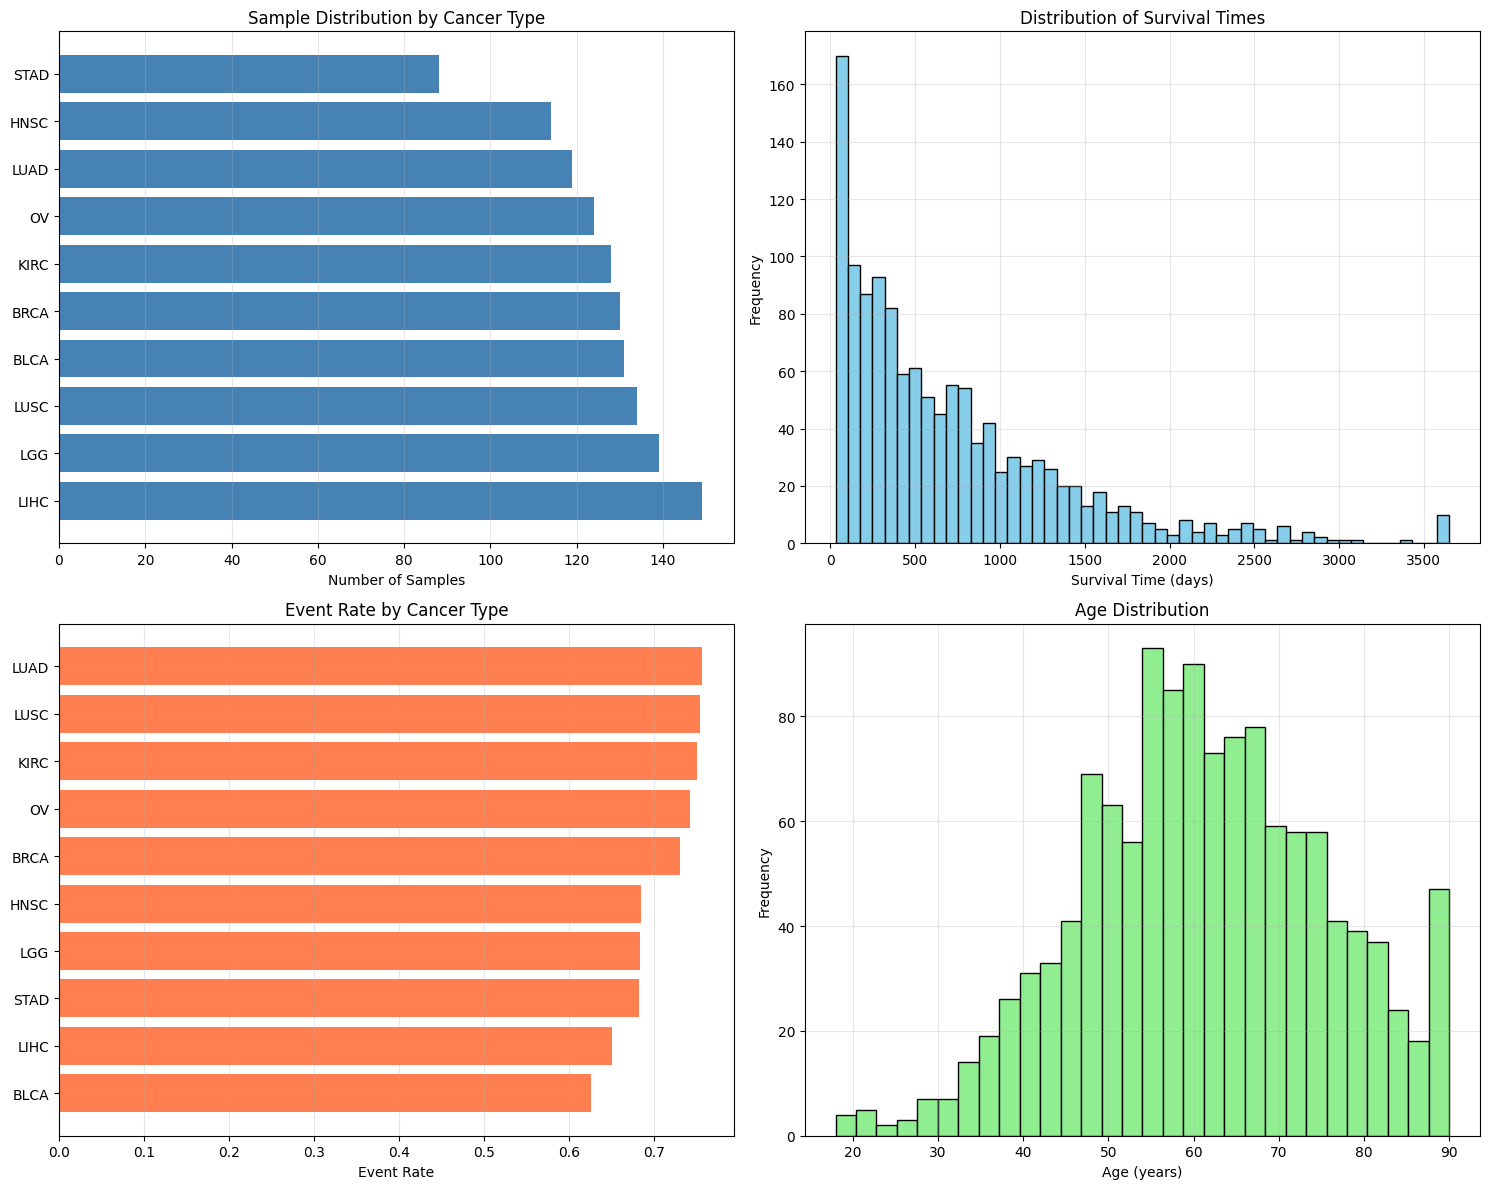


Dataset Summary Statistics:
Total samples: 1256
Total events: 886
Event rate: 70.54%
Mean survival time: 708.9 days
Median survival time: 519.6 days

By Cancer Type:
            survival_time         event    age
                     mean  median  mean   mean
cancer_type                                   
BLCA               733.83  558.46  0.63  60.86
BRCA               681.30  523.70  0.73  62.50
HNSC               825.52  645.04  0.68  58.33
KIRC               669.34  478.69  0.75  63.17
LGG                691.76  420.32  0.68  60.68
LIHC               711.07  601.10  0.65  62.33
LUAD               663.26  424.84  0.76  59.37
LUSC               651.38  476.66  0.75  60.09
OV                 748.94  585.49  0.74  61.49
STAD               735.88  371.40  0.68  61.02


In [ ]:
# Create visualization of dataset characteristics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Sample distribution by cancer type
cancer_type_counts = combined_clinical['cancer_type'].value_counts()
axes[0, 0].barh(cancer_type_counts.index, cancer_type_counts.values, color='steelblue')
axes[0, 0].set_xlabel('Number of Samples')
axes[0, 0].set_title('Sample Distribution by Cancer Type')
axes[0, 0].grid(True, alpha=0.3, axis='x')

# 2. Survival time distribution
axes[0, 1].hist(combined_clinical['survival_time'], bins=50, color='skyblue', edgecolor='black')
axes[0, 1].set_xlabel('Survival Time (days)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Survival Times')
axes[0, 1].grid(True, alpha=0.3)

# 3. Event rate by cancer type
event_rate_by_type = combined_clinical.groupby('cancer_type')['event'].mean().sort_values()
axes[1, 0].barh(event_rate_by_type.index, event_rate_by_type.values, color='coral')
axes[1, 0].set_xlabel('Event Rate')
axes[1, 0].set_title('Event Rate by Cancer Type')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# 4. Age distribution
axes[1, 1].hist(combined_clinical['age'], bins=30, color='lightgreen', edgecolor='black')
axes[1, 1].set_xlabel('Age (years)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Age Distribution')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nDataset Summary Statistics:")
print("=" * 60)
print(f"Total samples: {len(combined_clinical)}")
print(f"Total events: {combined_clinical['event'].sum()}")
print(f"Event rate: {combined_clinical['event'].mean():.2%}")
print(f"Mean survival time: {combined_clinical['survival_time'].mean():.1f} days")
print(f"Median survival time: {combined_clinical['survival_time'].median():.1f} days")
print(f"\nBy Cancer Type:")
print(combined_clinical.groupby('cancer_type').agg({
    'survival_time': ['mean', 'median'],
    'event': 'mean',
    'age': 'mean'
}).round(2))


## 4. Building Cox-nnet Model for Omics Data

### 4.1 Cox-nnet Architecture for High-Dimensional Data

For high-dimensional omics data, Cox-nnet typically uses:

- **Input Layer**: Number of features (genes or principal components)
- **Hidden Layer(s)**: One or more fully connected layers
  - For high-dimensional data, a single hidden layer with 10-50 units is often sufficient
  - More layers can capture complex interactions but may overfit
- **Output Layer**: Single unit (log-hazard ratio)
- **Regularization**: L2 penalty and dropout to prevent overfitting

**Key Considerations:**
- High-dimensional data (thousands of features) requires strong regularization
- Dropout helps prevent overfitting
- Batch normalization can stabilize training
- Early stopping is crucial


###  Define Cox partial log-likelihood loss function

In [ ]:
# Define Cox partial log-likelihood loss function
def cox_loss(y_true, y_pred):
    """
    Cox partial log-likelihood loss function for high-dimensional data.
    """
    time = y_true[:, 0]
    event = y_true[:, 1]
    risk = y_pred[:, 0]

    # Sort by time (ascending)
    sort_idx = tf.argsort(time, direction='ASCENDING')
    time_sorted = tf.gather(time, sort_idx)
    event_sorted = tf.gather(event, sort_idx)
    risk_sorted = tf.gather(risk, sort_idx)

    # Calculate exp(risk)
    exp_risk = tf.exp(risk_sorted)

    # Calculate risk set sum using reverse cumulative sum
    exp_risk_rev = tf.reverse(exp_risk, axis=[0])
    cumsum_rev = tf.cumsum(exp_risk_rev, axis=0)
    risk_set_sum = tf.reverse(cumsum_rev, axis=[0])

    # Calculate log of risk set sum
    log_risk_set = tf.math.log(risk_set_sum + 1e-8)

    # Calculate partial log-likelihood
    pll = tf.reduce_sum((risk_sorted - log_risk_set) * event_sorted)

    # Normalize by number of events
    n_events = tf.reduce_sum(event_sorted) + 1e-8
    loss = -pll / n_events

    return loss

print("✓ Cox loss function defined")


✓ Cox loss function defined


### Split Data int Training and Test Sets

In [ ]:
# Split data into training and test sets
X_train, X_test, t_train, t_test, f_train, f_test = train_test_split(
    X_final, y_time, y_event,
    test_size=0.3,
    random_state=42,
    stratify=y_event  # Stratify by event to maintain event rate
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Features: {X_train.shape[1]}")
print(f"\nTraining event rate: {f_train.mean():.2%}")
print(f"Test event rate: {f_test.mean():.2%}")


Training set: 879 samples
Test set: 377 samples
Features: 500

Training event rate: 70.53%
Test event rate: 70.56%


### Build Cox-nnet model for high-dimensional omics data

In [ ]:
# Build Cox-nnet model for high-dimensional omics data
def build_cox_nnet_omics(n_features, n_hidden=30, l2_reg=0.01, dropout_rate=0.5):
    """
    Build Cox-nnet model optimized for high-dimensional omics data.

    Parameters:
    -----------
    n_features : int
        Number of input features (genes or PCs)
    n_hidden : int
        Number of hidden units (typically 10-50 for omics data)
    l2_reg : float
        L2 regularization parameter
    dropout_rate : float
        Dropout rate for regularization

    Returns:
    --------
    model : keras.Model
        Compiled Cox-nnet model
    """
    model = keras.Sequential([
        layers.Dense(n_hidden,
                    input_dim=n_features,
                    activation='relu',
                    kernel_regularizer=keras.regularizers.l2(l2_reg),
                    name='hidden_layer'),
        layers.BatchNormalization(),  # Stabilize training
        layers.Dropout(dropout_rate),  # Strong dropout for high-dim data
        layers.Dense(1,
                    activation='linear',
                    kernel_regularizer=keras.regularizers.l2(l2_reg),
                    name='output_layer')
    ])

    return model

# Build model
n_features = X_train.shape[1]
cox_model = build_cox_nnet_omics(
    n_features=n_features,
    n_hidden=30,  # Adjust based on data size
    l2_reg=0.01,
    dropout_rate=0.5
)

# Prepare y_true for training
y_train_cox = np.column_stack([t_train, f_train])
y_test_cox = np.column_stack([t_test, f_test])

# Compile model
cox_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=cox_loss
)

print("Cox-nnet model architecture:")
cox_model.summary()


I0000 00:00:1765906350.074743 1043407 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13990 MB memory:  -> device: 0, name: Quadro P5000, pci bus id: 0000:d5:00.0, compute capability: 6.1


Cox-nnet model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer (Dense)            │ (None, 30)             │        15,030 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30)             │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,181 (59.30 KB)

 Trainable params: 15,121 (59.07 KB)

 Non-trainable params: 60 (240.00 B)

### Train the Cox-net Model

In [ ]:
# Train the Cox-nnet model
print("Training Cox-nnet model on omics data...")
print("=" * 60)

early_stopping = callbacks.EarlyStopping(
    monitor='loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

history = cox_model.fit(
    X_train, y_train_cox,
    batch_size=64,  # Smaller batch size for high-dim data
    epochs=300,
    verbose=1,
    callbacks=[early_stopping, reduce_lr],
    validation_split=0.2
)


Training Cox-nnet model on omics data...
Epoch 1/300


2025-12-16 12:32:36.905744: I external/local_xla/xla/service/service.cc:163] XLA service 0x7bc32c0060d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-16 12:32:36.905773: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Quadro P5000, Compute Capability 6.1
2025-12-16 12:32:36.952950: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-16 12:32:37.091256: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


 1/11 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 5.2783

I0000 00:00:1765906358.257491 1043714 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 261ms/step - loss: 5.3193 - val_loss: 5.5538 - learning_rate: 0.0010
Epoch 2/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.0195 - val_loss: 5.3140 - learning_rate: 0.0010
Epoch 3/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.7014 - val_loss: 5.1249 - learning_rate: 0.0010
Epoch 4/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.4877 - val_loss: 4.9792 - learning_rate: 0.0010
Epoch 5/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.3791 - val_loss: 4.8605 - learning_rate: 0.0010
Epoch 6/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.2601 - val_loss: 4.7556 - learning_rate: 0.0010
Epoch 7/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.1137 - val_loss: 4.6693 - learning_rate: 0.0010
Epoch 8/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.9902 - val_loss: 4.6030 - learning_rate: 0.0010
Epoch 9/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.8512 - val_loss: 4.5386 - learning_rate: 0.0010
Epoch 10/300
11/11 ━━

### Plot Training History

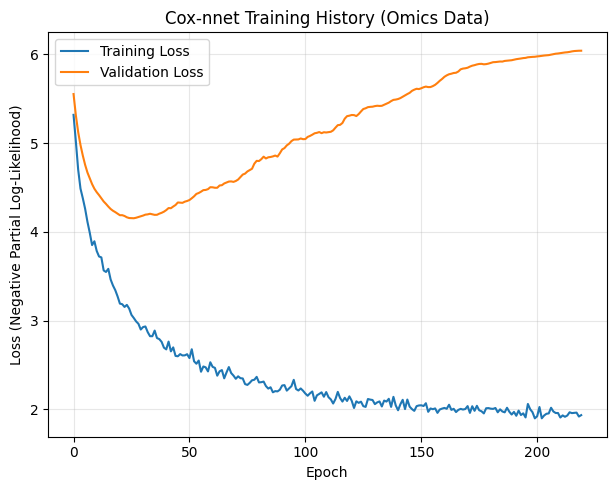

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Cox-nnet Training History (Omics Data)')
plt.xlabel('Epoch')
plt.ylabel('Loss (Negative Partial Log-Likelihood)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Model Evaluation


We'll evaluate the Cox-nnet model using:

1. **Concordance Index (C-index)**: Measures discrimination ability
2. **Risk Stratification**: Visualize survival curves by risk groups
3. **Cancer Type Analysis**: Evaluate performance across different cancer types


#### Make Prediction

In [ ]:
# Make predictions
risk_scores_train = cox_model.predict(X_train, verbose=0).flatten()
risk_scores_test = cox_model.predict(X_test, verbose=0).flatten()

# Calculate C-index
c_index_train = concordance_index(t_train, -risk_scores_train, f_train)
c_index_test = concordance_index(t_test, -risk_scores_test, f_test)

print("Model Performance Metrics:")
print("=" * 60)
print(f"Training C-index: {c_index_train:.4f}")
print(f"Test C-index: {c_index_test:.4f}")
print(f"\nInterpretation:")
print(f"A C-index of {c_index_test:.4f} means that in {c_index_test*100:.2f}% of comparable pairs,")
print(f"the model correctly predicts which patient will have the event first.")


Model Performance Metrics:
Training C-index: 0.8662
Test C-index: 0.4678

Interpretation:
A C-index of 0.4678 means that in 46.78% of comparable pairs,
the model correctly predicts which patient will have the event first.


#### Risk Stratification Visualization

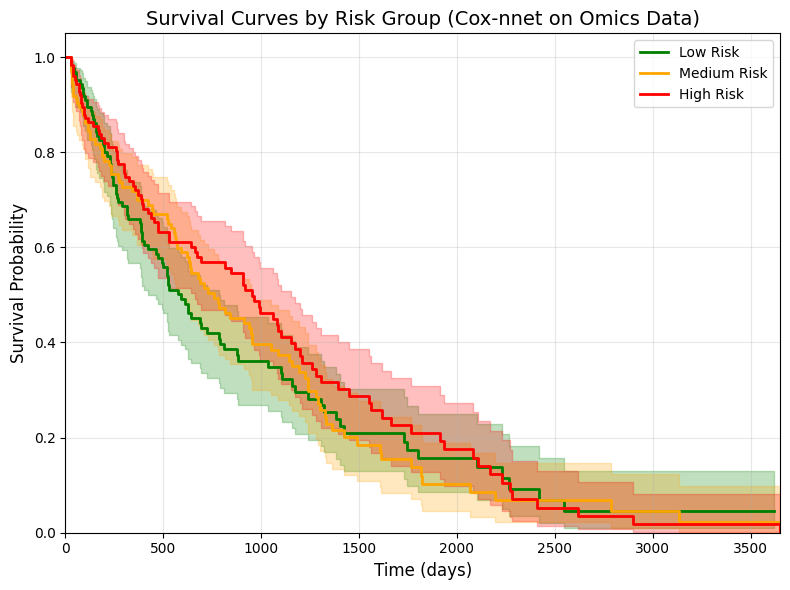


Risk group sizes:
Low risk: 126 patients
Medium risk: 125 patients
High risk: 126 patients


In [ ]:
# Risk stratification visualization
risk_tertiles = np.percentile(risk_scores_test, [33.3, 66.7])
low_risk = risk_scores_test <= risk_tertiles[0]
med_risk = (risk_scores_test > risk_tertiles[0]) & (risk_scores_test <= risk_tertiles[1])
high_risk = risk_scores_test > risk_tertiles[1]

plt.figure(figsize=(8, 6))

# Plot Kaplan-Meier curves for each risk group
for risk_group, label, color in zip([low_risk, med_risk, high_risk],
                                    ['Low Risk', 'Medium Risk', 'High Risk'],
                                    ['green', 'orange', 'red']):
    kmf_group = KaplanMeierFitter()
    kmf_group.fit(t_test[risk_group], event_observed=f_test[risk_group], label=f'{label}')
    kmf_group.plot_survival_function(ax=plt.gca(), color=color, linewidth=2)

plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Survival Probability', fontsize=12)
plt.title('Survival Curves by Risk Group (Cox-nnet on Omics Data)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim(0, min(3650, t_test.max() * 1.1))
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

print(f"\nRisk group sizes:")
print(f"Low risk: {low_risk.sum()} patients")
print(f"Medium risk: {med_risk.sum()} patients")
print(f"High risk: {high_risk.sum()} patients")


### Performance by Cancer Type

Let's evaluate how well the model performs for each cancer type:


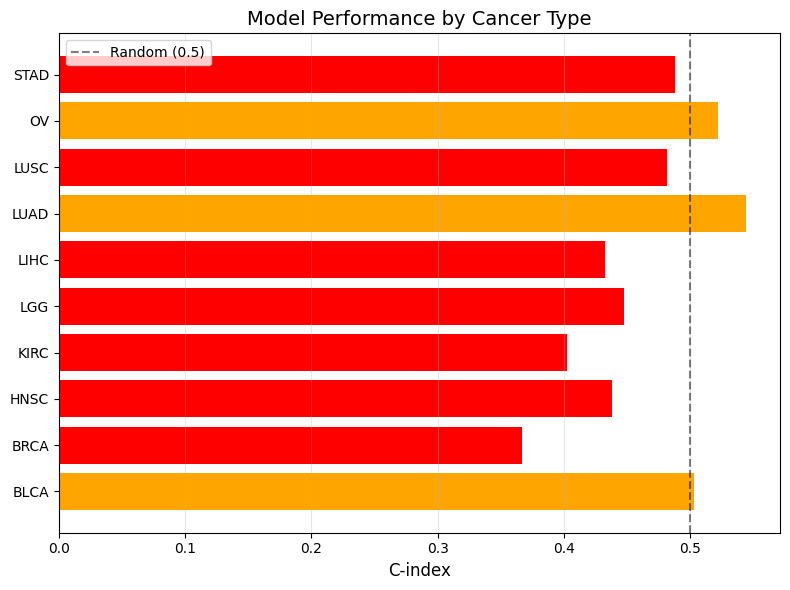


C-index by Cancer Type:
  LUAD: 0.5439
  OV: 0.5223
  BLCA: 0.5027
  STAD: 0.4878
  LUSC: 0.4817
  LGG: 0.4472
  HNSC: 0.4379
  LIHC: 0.4325
  KIRC: 0.4027
  BRCA: 0.3667


In [ ]:
# Get cancer types for test samples
test_indices = np.where(np.isin(np.arange(len(combined_clinical)),
                                 np.arange(len(combined_clinical))[train_test_split(
                                     np.arange(len(combined_clinical)),
                                     test_size=0.3,
                                     random_state=42,
                                     stratify=y_event
                                 )[1]]))[0]

# This is a simplified approach - in practice, track cancer types through train/test split
# For demonstration, we'll use the full dataset indices
test_cancer_types = combined_clinical.iloc[test_indices if len(test_indices) > 0 else
                                           train_test_split(
                                               np.arange(len(combined_clinical)),
                                               test_size=0.3,
                                               random_state=42,
                                               stratify=y_event
                                           )[1]]['cancer_type'].values

# Calculate C-index by cancer type
c_index_by_type = {}
for cancer_type in TCGA_CANCER_TYPES:
    mask = test_cancer_types == cancer_type
    if mask.sum() > 10:  # Need at least 10 samples
        c_idx = concordance_index(t_test[mask], -risk_scores_test[mask], f_test[mask])
        c_index_by_type[cancer_type] = c_idx

# Visualize
if c_index_by_type:
    plt.figure(figsize=(8, 6))
    cancer_types = list(c_index_by_type.keys())
    c_indices = list(c_index_by_type.values())

    colors = ['green' if c > 0.6 else 'orange' if c > 0.5 else 'red' for c in c_indices]
    plt.barh(cancer_types, c_indices, color=colors)
    plt.axvline(x=0.5, color='black', linestyle='--', alpha=0.5, label='Random (0.5)')
    plt.xlabel('C-index', fontsize=12)
    plt.title('Model Performance by Cancer Type', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

    print("\nC-index by Cancer Type:")
    for ct, ci in sorted(c_index_by_type.items(), key=lambda x: x[1], reverse=True):
        print(f"  {ct}: {ci:.4f}")
else:
    print("Insufficient samples per cancer type for individual evaluation")


###  Feature Importance Analysis

For high-dimensional omics data, understanding which genes or features are most important for prognosis prediction is crucial. However, Cox-nnet's neural network architecture makes direct interpretation challenging. We can use several approaches:

1. **Weight Analysis**: Examine first-layer weights
2. **Permutation Importance**: Measure performance decrease when features are shuffled
3. **Gradient-based Methods**: Analyze gradients with respect to inputs
4. **SHAP Values**: Shapley Additive Explanations (if using tree-based models)

For this tutorial, we'll demonstrate weight analysis and permutation importance.


Top 20 Principal Components by Importance:
 1. PC415: 1.7008
 2. PC106: 1.6548
 3. PC427: 1.5922
 4. PC88: 1.5036
 5. PC412: 1.3960
 6. PC205: 1.3942
 7. PC247: 1.3774
 8. PC232: 1.3493
 9. PC495: 1.3092
10. PC80: 1.3023
11. PC32: 1.2574
12. PC466: 1.2461
13. PC264: 1.2438
14. PC204: 1.2429
15. PC199: 1.2292
16. PC21: 1.2083
17. PC97: 1.1940
18. PC430: 1.1926
19. PC212: 1.1748
20. PC347: 1.1744


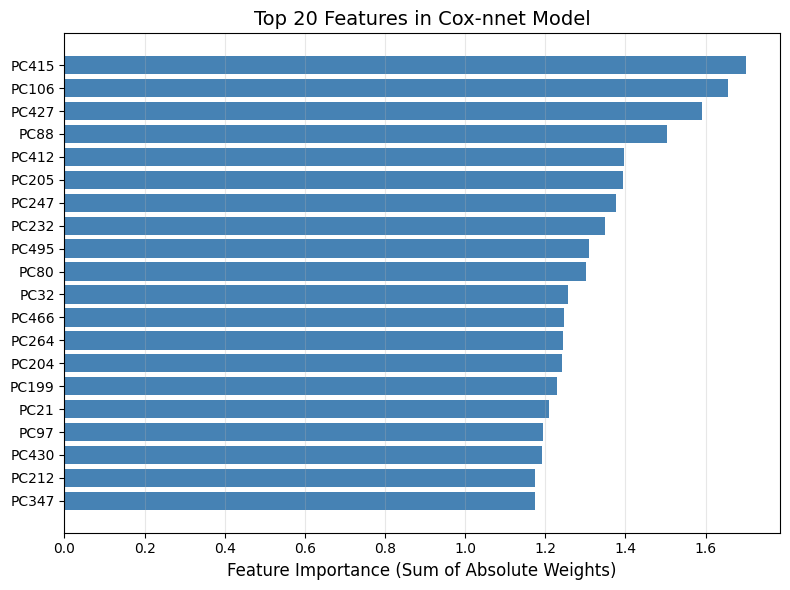

In [ ]:
# Extract weights from the first layer
hidden_layer_weights = cox_model.layers[0].get_weights()[0]  # Shape: (n_features, n_hidden)

# Calculate feature importance as the sum of absolute weights
feature_importance = np.abs(hidden_layer_weights).sum(axis=1)

# Get top features
top_n = 20
top_indices = np.argsort(feature_importance)[-top_n:][::-1]

# If we used PCA, we can't directly map back to genes
# Otherwise, we can use gene names
if use_pca:
    print(f"Top {top_n} Principal Components by Importance:")
    for i, idx in enumerate(top_indices, 1):
        print(f"{i:2d}. PC{idx}: {feature_importance[idx]:.4f}")
else:
    print(f"Top {top_n} Genes by Importance:")
    top_genes = [selected_genes[idx] for idx in top_indices]
    for i, (gene, idx) in enumerate(zip(top_genes, top_indices), 1):
        print(f"{i:2d}. {gene}: {feature_importance[idx]:.4f}")

# Visualize top features
plt.figure(figsize=(8, 6))
top_importance = feature_importance[top_indices]
if use_pca:
    labels = [f'PC{i}' for i in top_indices]
else:
    labels = [selected_genes[i] for i in top_indices]

plt.barh(range(len(top_importance)), top_importance, color='steelblue')
plt.yticks(range(len(labels)), labels)
plt.xlabel('Feature Importance (Sum of Absolute Weights)', fontsize=12)
plt.title(f'Top {top_n} Features in Cox-nnet Model', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


### Summary and Conclusion

Cox-nnet emerges as a powerful hybrid approach for survival analysis in high-throughput omics settings, effectively merging the Cox proportional hazards model with the flexibility of neural networks. This integration enables the modeling of complex, non-linear relationships between gene expression profiles and patient survival outcomes, while simultaneously managing the challenges posed by high dimensionality. Key strengths include its capacity to process thousands of genes concurrently, automatically learn relevant features, capture intricate gene–gene interactions, and incorporate regularization techniques that mitigate overfitting—critical in omics contexts where features vastly outnumber samples. However, successful application demands careful data preprocessing such as variance filtering and feature standardization, and may benefit from dimensionality reduction strategies like PCA when dealing with ultra-high-dimensional inputs. Interpretability remains a notable limitation compared to simpler linear models, underscoring the need for complementary methods to identify biologically meaningful predictors. Best practices emphasize robust regularization (e.g., L2 penalties, dropout), early stopping, and performance evaluation across diverse cancer types to ensure generalizability. The method has already demonstrated utility in cancer prognosis, biomarker discovery, multi-cancer analyses, and personalized medicine. Looking ahead, promising avenues include integrating attention mechanisms for enhanced interpretability, enabling multi-omics data fusion, leveraging transfer learning across tumor types, and extending the framework to accommodate time-varying molecular profiles.


## 8. Resources

### Research Papers

1. **Ching, T., Zhu, X., & Garmire, L. X. (2018)**. Cox-nnet: An artificial neural network method for prognosis prediction of high-throughput omics data. *PLoS computational biology*, 14(4), e1006076.
   - URL: https://pmc.ncbi.nlm.nih.gov/articles/PMC5909924/
   - DOI: 10.1371/journal.pcbi.1006076

2. **The Cancer Genome Atlas Research Network** (2013). The Cancer Genome Atlas Pan-Cancer analysis project. *Nature Genetics*, 45(10), 1113-1120.

### Data Sources

1. **GDC Data Portal**
   - URL: https://portal.gdc.cancer.gov/
   - Official TCGA data access portal
   - Requires registration and data use agreement

2. **UCSC Xena Browser**
   - URL: https://xenabrowser.net/
   - Pre-processed TCGA data
   - Easy download of expression and clinical data
   - Multiple normalization options

3. **cBioPortal**
   - URL: https://www.cbioportal.org/
   - Interactive exploration and download of TCGA data
   - Integrated analysis tools

### Software and Tools

1. **Cox-nnet GitHub Repository**
   - URL: https://github.com/lanagarmire/cox-nnet
   - Original R implementation

2. **TCGAbiolinks (R package)**
   - URL: https://bioconductor.org/packages/TCGAbiolinks/
   - R package for TCGA data download and analysis
   - Has Python wrapper available

3. **GDC API**
   - URL: https://docs.gdc.cancer.gov/API/PDF/API_UG.pdf
   - Programmatic access to TCGA data

### Additional Reading

1. **TCGA Data Analysis**
   - Comprehensive guides on TCGA data processing
   - Best practices for RNA-Seq analysis

2. **Survival Analysis with Omics Data**
   - Review papers on high-dimensional survival analysis
   - Feature selection methods for omics data

3. **Neural Networks for Genomics**
   - Deep learning applications in genomics
   - Interpretability methods for neural networks
